# Statistical inference and estimation theory

We shall demonstrate how stochastic simulation can be used to verify theoretical ideas from **statistical inference and estimation theory**.

The following is needed to enable inlining of Matplotlib graphs in this Jypyter notebook:

In [1]:
%matplotlib inline

Now let us import some Python libraries and set some settings.

In [2]:
import random as rnd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 16,10

import seaborn as sns

Let us generate (simulate) a population of 500000. We shall use a single feature drawn from a 

In [3]:
population_size = 500000
a = 0; b = 100
population = [rnd.randint(a, b) for _ in range(population_size)]

Of course, there is the usual caveat: **Garbage In, Garbage Out**. Our inferences can only be as good as the (pseudo-) random variates that we generate. In this study we take these random variates as our gold standard, and we compare things against them. In practice, the random number generators are never perfect.

Most functions in Python's *random* module depend on *random.random()* under the hood, which uses a threadsafe C implementation of the Mersenne Twister algorithm as the core generator. It produces 53-bit precision floats and has a period of 2\*\*19937-1. Mersenne Twister is a completely deterministic generator of pseudo-random numbers.

For a discussion of its quality, we refer the reader to https://stackoverflow.com/questions/12164280/is-pythons-random-randint-statistically-random

The statistical properties of the variates generated are good enough for our purposes. It is still a good idea to check that our population "looks like" it has a discrete uniform distribution, as it should. Matplotlib's histogram should be good enough for that:

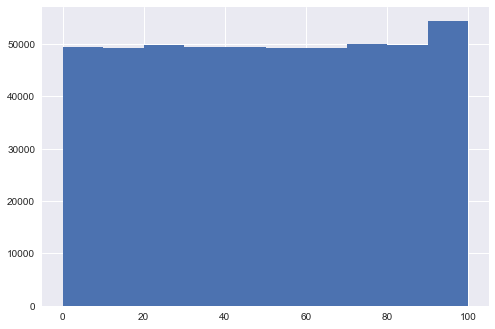

In [4]:
plt.hist(population);

Although seaborn's *distplot* looks more elegant:

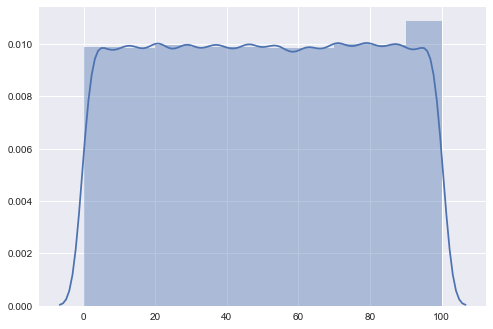

In [5]:
sns.distplot(population, bins=10);

Let's introduce an implementation of the **sample mean** estimator:

In [6]:
def mean(x): return sum(x) / len(x)

Python lambda fans will probably prefer this variant, although there is little benefit from using a lambda here as it is not passed to a function as an argument:

In [7]:
mean = lambda x: sum(x) / len(x)

We'll also introduce an implementation of ***uncorrected*** **sample variance**:

In [8]:
def var(x, m=None):
    m = m or mean(x)
    return sum([(xe - m)**2 for xe in x]) / len(x)

What estimates do we get if we use the entire population as our sample?

In [9]:
population_mean = mean(population)
population_var = var(population, population_mean)
print("population mean: {:.2f}, population variance: {:.2f}".format(population_mean, population_var))

population mean: 50.03, population variance: 850.51


The true values for the discrete uniform random variable are given by $$\mathbb{E}[X] = \frac{a+b}{2}$$ and $$\text{Var}[X] = \frac{(b - a + 1)^2 - 1}{12}.$$

In [10]:
true_mean = .5 * (a + b); true_mean

50.0

In [11]:
true_var = ((b - a + 1.)**2 - 1) / 12.; true_var

850.0

Our estimates above are pretty close. What if we now pick a smaller sample?

In [12]:
sample = rnd.sample(population, 10)
sample_mean = mean(sample)
sample_var = var(sample)
print("sample mean: {:.2f}, sample variance: {:.2f}".format(sample_mean, sample_var))

sample mean: 26.80, sample variance: 965.76


Not quite as good! Let us stick with this small sample size, 10, and compute the sampling distribution of our estimators by computing them for many samples of the same size.

In [13]:
sample_means, sample_vars = [], []
for _ in range(100000):
    sample = rnd.sample(population, 10)
    m = mean(sample)
    sample_means.append(m)
    sample_vars.append(var(sample, m))

Let's use a histogram to visualise the sampling distribution for the sample mean estimator:

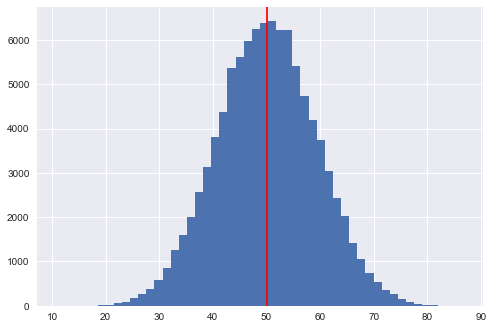

In [14]:
plt.hist(sample_means, 50)
plt.axvline(true_mean, color='red');

This looks pretty centred around the true value, so the estimator appears unbiased. What about the sampling distribution of the uncorrected sample variance estimator?

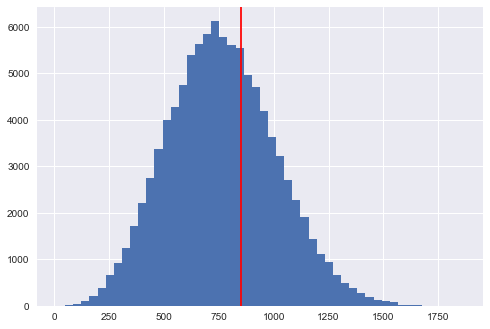

In [15]:
plt.hist(sample_vars, 50);
plt.axvline(true_var, color='red');

This time the distribution is to the left of the true population variance, so it appears that we are systematically underestimating it: the uncorrected sample variance estimator is biased.

How does its value change as we increase the sample size?

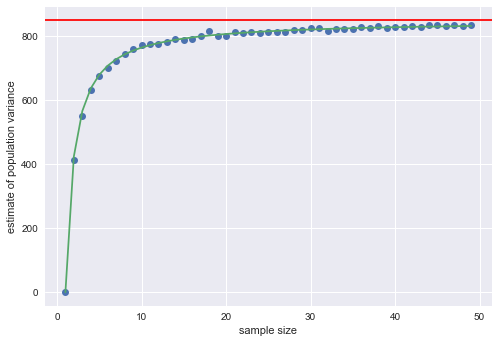

In [16]:
sample_sizes, sample_vars = [], []
for ss in range(1, 50):
    sample_sizes.append(ss)
    sample_vars.append(mean([var(rnd.sample(population, ss)) for _ in range(1000)]))
plt.plot(sample_sizes, sample_vars, 'o')
plt.axhline(true_var, color='red')
plt.plot(sample_sizes, [(n-1)/n * true_var for n in sample_sizes])
plt.xlabel('sample size')
plt.ylabel('estimate of population variance');

Looks like it gets closer to the true value, although a certain bias remains visible on the plot.

Will the (corrected) **sample variance** estimator do better? Let's implement it...

In [17]:
def sample_var(x, m=None):
    m = m or mean(x)
    n = len(x)
    return n/(n-1) * var(x, m)

...and compare the uncorrected and corrected sample variance:

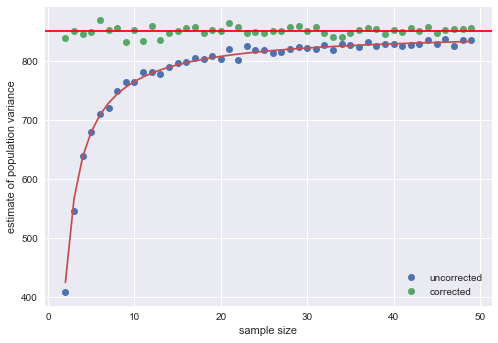

In [18]:
sample_sizes, sample_vars, sample_vars1 = [], [], []
for ss in range(2, 50):
    sample_sizes.append(ss)
    sample_vars.append(mean([var(rnd.sample(population, ss)) for _ in range(1000)]))
    sample_vars1.append(mean([sample_var(rnd.sample(population, ss)) for _ in range(1000)]))
plt.plot(sample_sizes, sample_vars, 'o', label='uncorrected')
plt.plot(sample_sizes, sample_vars1, 'o', label='corrected')
plt.axhline(true_var, color='red')
plt.plot(sample_sizes, [(n-1)/n * true_var for n in sample_sizes])
plt.xlabel('sample size')
plt.ylabel('estimate of population variance')
plt.legend();

The (corrected) sample variance is clearly unbiased. Let us confirm this by visualising its sampling distribution with a histogram:

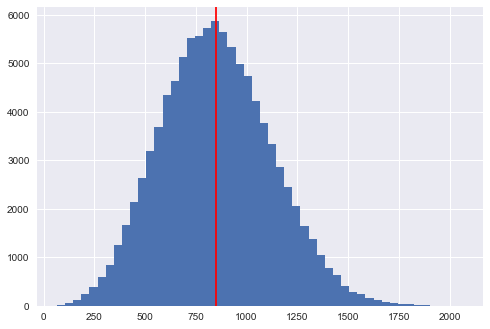

In [19]:
sample_means, sample_vars = [], []
for _ in range(100000):
    sample = rnd.sample(population, 10)
    m = mean(sample)
    sample_vars.append(sample_var(sample, m))
    
plt.hist(sample_vars, 50)
plt.axvline(true_var, color='red');

Now let us demonstrate the concept of **consistency**. We introduce two more estimators of the mean. The first will be consistent but biased, the second unbiased but inconsistent:

In [20]:
def mean1(x): return (sum(x) + 10.) / len(x)
def mean2(x): return x[0]

Let's see how these estimators perform:

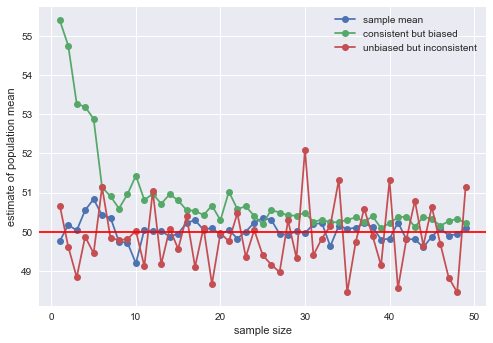

In [21]:
sample_sizes, sample_means, sample_means1, sample_means2 = [], [], [], []
for ss in range(1, 50):
    sample_sizes.append(ss)
    sample_means.append(mean([mean(rnd.sample(population, ss)) for _ in range(1000)]))
    sample_means1.append(mean([mean1(rnd.sample(population, ss)) for _ in range(1000)]))
    sample_means2.append(mean([mean2(rnd.sample(population, ss)) for _ in range(1000)]))
plt.plot(sample_sizes, sample_means, 'o-', label='sample mean')
plt.plot(sample_sizes, sample_means1, 'o-', label='consistent but biased')
plt.plot(sample_sizes, sample_means2, 'o-', label='unbiased but inconsistent')
plt.axhline(true_mean, color='red')
plt.xlabel('sample size')
plt.ylabel('estimate of population mean')
plt.legend();

Now let's see how well the square roots of the square roots of the uncorrected and corrected sample variance estimate the standard deviation:

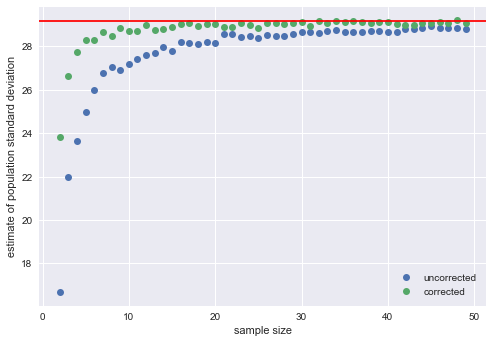

In [22]:
import math
sample_sizes, sample_sds, sample_sds1 = [], [], []
for ss in range(2, 50):
    sample_sizes.append(ss)
    sample_sds.append(mean([math.sqrt(var(rnd.sample(population, ss))) for _ in range(1000)]))
    sample_sds1.append(mean([math.sqrt(sample_var(rnd.sample(population, ss))) for _ in range(1000)]))
plt.plot(sample_sizes, sample_sds, 'o', label='uncorrected')
plt.plot(sample_sizes, sample_sds1, 'o', label='corrected')
plt.axhline(math.sqrt(true_var), color='red')
plt.xlabel('sample size')
plt.ylabel('estimate of population standard deviation')
plt.legend();

Notice that although the square root of the *corrected* sample variance does much better and in practice would be a pretty good estimator for the standard deviation of this (the discrete uniform) distribution, most of the points lie below the red line representing the true value, so a small bias remains.